# Aim

This project looks at buiding a models to classify a cat breed. The model will then be used by a cat calssification web application which will rasie awareness for cat adoption

The project will begin by loading in the dataset of cat breeds gotten from https://www.kaggle.com/ma7555/cat-breeds-dataset

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras 
import IPython.display as display
from PIL import Image , ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Data Stats

In [10]:
data_stats = pd.read_csv('../input/cat-breeds-dataset/data/cats.csv')

In [11]:
data_stats.head(10)

,Unnamed: 0,id,url,type,age,gender,size,coat,breed,photos,med_photos
0,0,46744842,https://www.petfinder.com/cat/arianna-46744842...,Cat,Adult,Female,Medium,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
1,1,46717321,https://www.petfinder.com/cat/ozzy-46717321/oh...,Cat,Adult,Male,Extra Large,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
2,2,46626338,https://www.petfinder.com/cat/zena-46626338/ca...,Cat,Senior,Female,Medium,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
3,3,46620170,https://www.petfinder.com/cat/mika-46620170/ca...,Cat,Baby,Female,Small,Short,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
4,4,46582751,https://www.petfinder.com/cat/ruby-46582751/fl...,Cat,Young,Female,Medium,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
5,5,46503423,https://www.petfinder.com/cat/dakota-46503423/...,Cat,Young,Male,Medium,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
6,6,46499754,https://www.petfinder.com/cat/triscuit-4649975...,Cat,Adult,Female,Medium,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
7,7,46463847,https://www.petfinder.com/cat/kingston-4646384...,Cat,Adult,Male,Medium,Short,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
8,8,46434624,https://www.petfinder.com/cat/exy-46434624/tx/...,Cat,Baby,Female,Small,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...
9,9,46378434,https://www.petfinder.com/cat/dusty-46378434/i...,Cat,Baby,Male,Small,NaN,Abyssinian,[{'small': 'https://dl5zpyw5k3jeb.cloudfront.n...,['https://dl5zpyw5k3jeb.cloudfront.net/photos/...


In [12]:
data_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67145 entries, 0 to 67144
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  67145 non-null  int64 
 1   id          67145 non-null  int64 
 2   url         67145 non-null  object
 3   type        67145 non-null  object
 4   age         67145 non-null  object
 5   gender      67145 non-null  object
 6   size        67145 non-null  object
 7   coat        42012 non-null  object
 8   breed       67145 non-null  object
 9   photos      67145 non-null  object
 10  med_photos  67145 non-null  object
dtypes: int64(2), object(9)
memory usage: 5.6+ MB


In [13]:
data_stats.describe()

,Unnamed: 0,id
count,67145.000000,6.714500e+04
mean,35788.295003,4.044119e+07
std,20523.476522,7.418863e+06
min,0.000000,6.251749e+06
25%,18424.000000,3.557538e+07
50%,35223.000000,4.429353e+07
75%,53739.000000,4.624314e+07
max,70988.000000,4.681097e+07


In [14]:
data_stats['gender'].astype('category')
data_stats['age'].astype('category')
data_stats['breed'].astype('category').head(10)

0    Abyssinian
1    Abyssinian
2    Abyssinian
3    Abyssinian
4    Abyssinian
5    Abyssinian
6    Abyssinian
7    Abyssinian
8    Abyssinian
9    Abyssinian
Name: breed, dtype: category
Categories (67, object): [Abyssinian, American Bobtail, American Curl, American Shorthair, ..., Turkish Angora, Turkish Van, Tuxedo, York Chocolate]

In [15]:
data_stats[['breed', 'id']].groupby(['breed'], as_index=False).count().sort_values(by='id', ascending=False)

,breed,id
25,Domestic Short Hair,4049
44,Persian,3999
23,Domestic Long Hair,3967
3,American Shorthair,3964
24,Domestic Medium Hair,3819
...,...,...
19,Cymric,17
12,Burmilla,8
14,Canadian Hairless,4
17,Chinchilla,3


In [16]:
data_stats[['breed', 'id']].groupby(['breed'], as_index=False).count().sort_values(by='id', ascending=False).describe()

,id
count,67.000000
mean,1002.164179
std,1254.307096
min,1.000000
25%,107.000000
50%,258.000000
75%,1621.500000
max,4049.000000


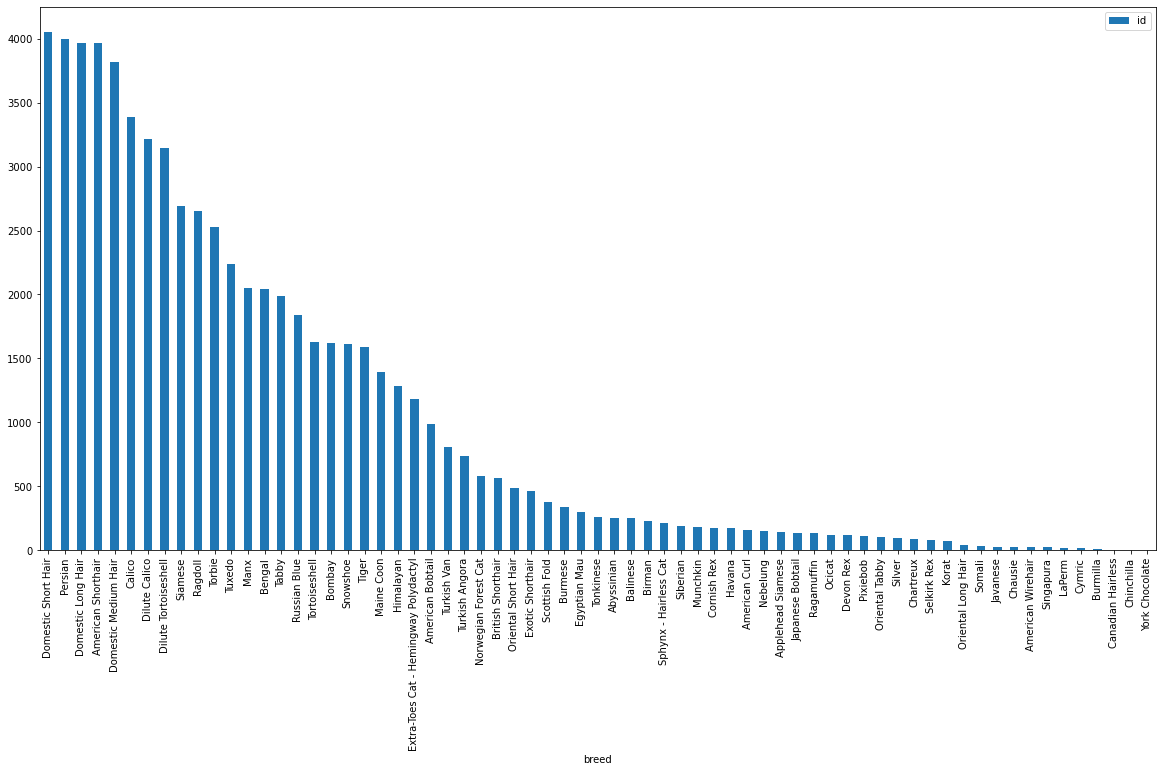

In [17]:
ax = data_stats[['breed', 'id']].groupby(['breed'], as_index=False).count().sort_values(by='id', ascending=False).plot.bar(x='breed', y='id',  figsize=(20, 10))

In [18]:
data_stats[['gender', 'id']].groupby(['gender'], as_index=False).count().sort_values(by='id', ascending=False)

,gender,id
0,Female,40667
1,Male,26476
2,Unknown,2


In [19]:
data_stats[['age', 'id']].groupby(['age'], as_index=False).count().sort_values(by='id', ascending=False)

,age,id
1,Baby,24663
0,Adult,22910
3,Young,16624
2,Senior,2948


In [20]:
data_stats[['type', 'id']].groupby(['type'], as_index=False).count().sort_values(by='id', ascending=False)

,type,id
0,Cat,67145


## Load Data

In [21]:
data_dir_str = '../input/cat-breeds-dataset/images/'
data_dir = pathlib.Path(data_dir_str)
image_count = len(list(data_dir.glob('*/*.jpg')))
print('image count',image_count)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt" and item.name != ".DS_Store"])
print('class count',len(CLASS_NAMES))
sorted(CLASS_NAMES)

image count 126607
class count 67


['Abyssinian',
 'American Bobtail',
 'American Curl',
 'American Shorthair',
 'American Wirehair',
 'Applehead Siamese',
 'Balinese',
 'Bengal',
 'Birman',
 'Bombay',
 'British Shorthair',
 'Burmese',
 'Burmilla',
 'Calico',
 'Canadian Hairless',
 'Chartreux',
 'Chausie',
 'Chinchilla',
 'Cornish Rex',
 'Cymric',
 'Devon Rex',
 'Dilute Calico',
 'Dilute Tortoiseshell',
 'Domestic Long Hair',
 'Domestic Medium Hair',
 'Domestic Short Hair',
 'Egyptian Mau',
 'Exotic Shorthair',
 'Extra-Toes Cat - Hemingway Polydactyl',
 'Havana',
 'Himalayan',
 'Japanese Bobtail',
 'Javanese',
 'Korat',
 'LaPerm',
 'Maine Coon',
 'Manx',
 'Munchkin',
 'Nebelung',
 'Norwegian Forest Cat',
 'Ocicat',
 'Oriental Long Hair',
 'Oriental Short Hair',
 'Oriental Tabby',
 'Persian',
 'Pixiebob',
 'Ragamuffin',
 'Ragdoll',
 'Russian Blue',
 'Scottish Fold',
 'Selkirk Rex',
 'Siamese',
 'Siberian',
 'Silver',
 'Singapura',
 'Snowshoe',
 'Somali',
 'Sphynx - Hairless Cat',
 'Tabby',
 'Tiger',
 'Tonkinese',
 'Torbi

In [22]:
# data_dir = pathlib.Path('data')
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir_str),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                    subset='training')
validation_data_gen = image_generator.flow_from_directory(directory=str(data_dir_str),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                   subset='validation')

Found 101313 images belonging to 67 classes.
Found 25294 images belonging to 67 classes.


In [23]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(12,12))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(8,4,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')

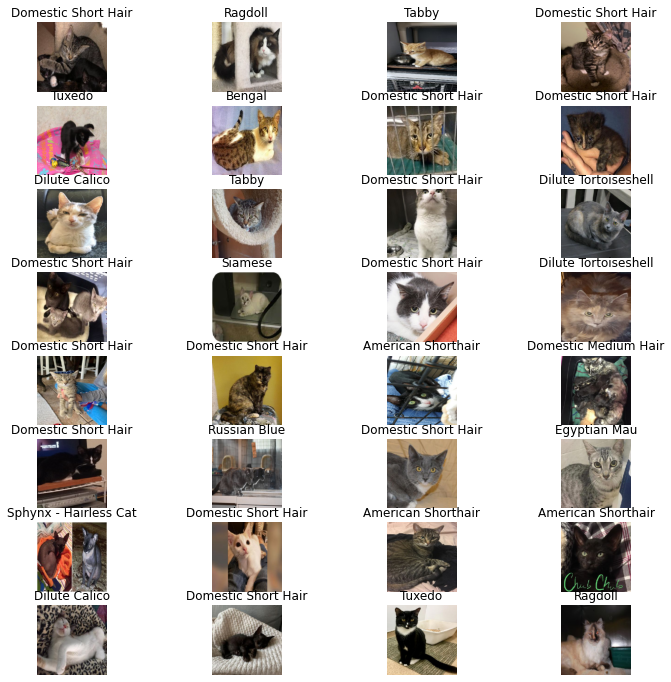

In [24]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

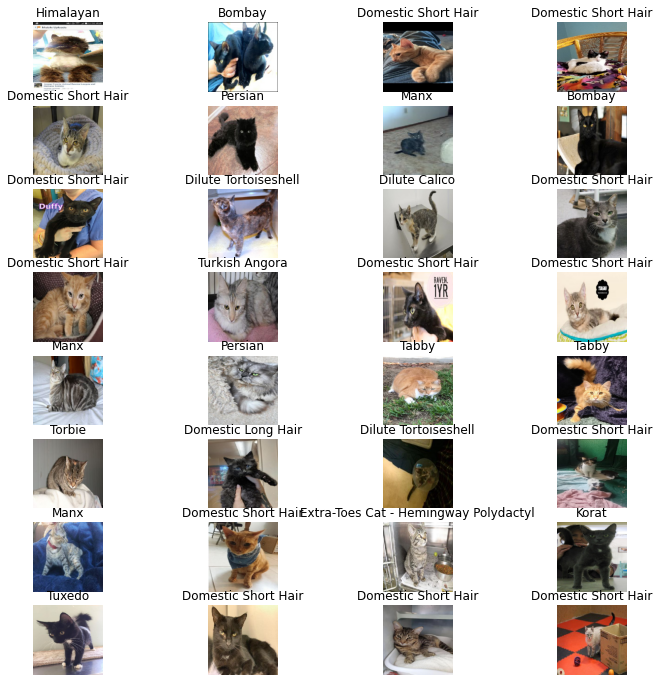

In [25]:
image_batch, label_batch = next(validation_data_gen)
show_batch(image_batch, label_batch)

## Detecting a domestic cat 

In [26]:
import urllib.request, json 
with urllib.request.urlopen("https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json") as url:
    data = json.loads(url.read().decode())
    print(data)

{'0': ['n01440764', 'tench'], '1': ['n01443537', 'goldfish'], '2': ['n01484850', 'great_white_shark'], '3': ['n01491361', 'tiger_shark'], '4': ['n01494475', 'hammerhead'], '5': ['n01496331', 'electric_ray'], '6': ['n01498041', 'stingray'], '7': ['n01514668', 'cock'], '8': ['n01514859', 'hen'], '9': ['n01518878', 'ostrich'], '10': ['n01530575', 'brambling'], '11': ['n01531178', 'goldfinch'], '12': ['n01532829', 'house_finch'], '13': ['n01534433', 'junco'], '14': ['n01537544', 'indigo_bunting'], '15': ['n01558993', 'robin'], '16': ['n01560419', 'bulbul'], '17': ['n01580077', 'jay'], '18': ['n01582220', 'magpie'], '19': ['n01592084', 'chickadee'], '20': ['n01601694', 'water_ouzel'], '21': ['n01608432', 'kite'], '22': ['n01614925', 'bald_eagle'], '23': ['n01616318', 'vulture'], '24': ['n01622779', 'great_grey_owl'], '25': ['n01629819', 'European_fire_salamander'], '26': ['n01630670', 'common_newt'], '27': ['n01631663', 'eft'], '28': ['n01632458', 'spotted_salamander'], '29': ['n01632777', 

Model was unable to identify cats like the hairless Sphynx, resnet50 was the closest

In [27]:
model = ResNet50(weights='imagenet')
# model = ResNet50(weights='imagenet')
# model = MobileNetV2(weights='imagenet')
# img_path = 'data/images/Tuxedo/46802281_32.jpg'
# img_path = 'data/images/Bengal/18644243_9136.jpg'
img_path = '../input/cat-breeds-dataset/images/Sphynx - Hairless Cat/25227058_230.jpg'
img = image.load_img(img_path, target_size=(224, 224))
# img = image.load_img(img_path, target_size=(299, 299))
# img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])


40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02113978', 'Mexican_hairless', 0.9628965), ('n02124075', 'Egyptian_cat', 0.0049531073), ('n02092339', 'Weimaraner', 0.0048596174)]


In [28]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [29]:
print(np.argmax(preds))

268


In [30]:
def is_a_domestic_cat(preds):
    max_prediction = np.argmax(preds)
    if 281<= max_prediction and max_prediction >=285:
        return True
    return False

In [31]:
is_a_domestic_cat(preds)

False

## Predicting cat breed

In [32]:
# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(67, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit(train_data_gen, 
          validation_data=(train_data_gen),
          epochs=5, verbose=1)
# input_tensor = Input(shape=(224, 224, 3))

# model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=True)


Train for 3167 steps, validate for 3167 steps
Epoch 1/5
3167/3167 [==============================] - 1431s 452ms/step - loss: 2.1743 - accuracy: 0.4630 - val_loss: 4.1871 - val_accuracy: 0.4187
Epoch 2/5
3167/3167 [==============================] - 1293s 408ms/step - loss: 2.0963 - accuracy: 0.4802 - val_loss: 7.6734 - val_accuracy: 0.4187
Epoch 3/5
3167/3167 [==============================] - 1266s 400ms/step - loss: 2.1223 - accuracy: 0.4814 - val_loss: 9.1711 - val_accuracy: 0.4187
Epoch 4/5
3167/3167 [==============================] - 1257s 397ms/step - loss: 2.1578 - accuracy: 0.4821 - val_loss: 9.6813 - val_accuracy: 0.4187
Epoch 5/5
3167/3167 [==============================] - 1256s 396ms/step - loss: 2.1903 - accuracy: 0.4833 - val_loss: 9.9318 - val_accuracy: 0.4187


In [62]:
model.save('cat_class_model')


In [63]:
reconstructed_model = keras.models.load_model('cat_class_model')

In [64]:
# comparing saved and tested model

sample_img_path = '../input/sample_cat/siamese_cat_1.jpeg'
sample_img = image.load_img(sample_img_path, target_size=(224, 224))
sample_x = image.img_to_array(img)
sample_x = np.expand_dims(sample_x, axis=0)
# sample_x = preprocess_input(x)


In [66]:
np.testing.assert_allclose(
  sample_x,sample_x)

In [67]:
np.testing.assert_allclose(
  model.predict(sample_x),
  reconstructed_model.predict(sample_x))

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 52 / 67 (77.6%)
Max absolute difference: 7.0780516e-08
Max relative difference: 2.6722644e-05
 x: array([[2.857643e-23, 9.427284e-16, 4.350386e-11, 4.726011e-04,
        3.148389e-07, 5.812387e-10, 1.337984e-12, 1.559243e-04,
        7.362746e-12, 7.522798e-16, 4.162422e-13, 9.607208e-01,...
 y: array([[2.857567e-23, 9.427211e-16, 4.350369e-11, 4.726011e-04,
        3.148389e-07, 5.812365e-10, 1.337984e-12, 1.559246e-04,
        7.362690e-12, 7.522712e-16, 4.162406e-13, 9.607208e-01,...

In [68]:
model_pred = model.predict(sample_x)
np.argmax(model_pred)


11

In [69]:
re_model_pred = reconstructed_model.predict(sample_x)
res = np.argmax(re_model_pred)


In [70]:
CLASS_NAMES[res]

'Domestic Short Hair'